In [1]:
!/opt/conda/bin/conda install -y --quiet -c plotly plotly

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pylab as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from collections import defaultdict

# Description

This notebook demonstrates how to play with jpxlab.

# Preparation

**(caution)** This requires about 55GB of local disk space

## Download files from FTP server (all files for 2019 September)

```
$ cd tools/fetcher
$ ./fetch.sh '201909??'
```

## Convert raw FLEX stream into dataframe

```
$ python cli.py convert /opt/jpxlab/downloads/*.zip
```

## Resample ticks to hourly candles

```
$ python cli.py resample -f 1H /opt/jpxlab/downloads/*.h5
```

# Security List

In [3]:
tbl = pd.read_excel("https://www.jpx.co.jp/english/markets/statistics-equities/misc/tvdivq0000001vg2-att/data_e.xls")

def lookup_security_info(code):
    if type(code) is not int:
        code = int(code[-4:])
    return tbl[tbl["Local Code"] == code]

def lookup_top_100():
    return tbl[
        (tbl["Size (New Index Series)"] == 'TOPIX Large70') | 
        (tbl["Size (New Index Series)"] == 'TOPIX Core30')]

# Loading data - Multiple Files (only top 100 securites)

In [4]:
buf = defaultdict(list)

keys = lookup_top_100()["Local Code"].values

for file in glob.glob("/opt/jpxlab/downloads/StandardEquities_201909??_1H.h5"):
    with pd.HDFStore(file, "r") as h5:
        for k in keys:
            k = "t{}".format(k)
            buf[k].append(h5[k])
top_100 = dict(list(map(
    lambda k: (k, pd.concat(buf[k]).sort_index()),
    buf.keys()
)))

In [5]:
top_100["t7203"].head()

,open,high,low,close,volume,amount
time,,,,,,
2019-09-02 09:00:00,6967.0,6973.0,6940.0,6949.0,1071400.0,7.457961e+09
2019-09-02 10:00:00,6949.0,6966.0,6945.0,6965.0,464000.0,3.229453e+09
2019-09-02 11:00:00,6965.0,6971.0,6963.0,6963.0,190900.0,1.329941e+09
2019-09-02 12:00:00,6949.0,6966.0,6946.0,6966.0,255000.0,1.773506e+09
2019-09-02 13:00:00,6966.0,6978.0,6964.0,6970.0,311900.0,2.174106e+09


## Extract `amount` column

In [6]:
amounts = pd.concat(
    [
        v.amount.to_frame(k)
        for k, v in top_100.items()
    ],
    axis=1
)

In [7]:
amounts.head()

,t1605,t1878,t1925,t1928,t2502,t2503,t2802,t2914,t3382,t3402,...,t9433,t9434,t9437,t9502,t9503,t9531,t9735,t9843,t9983,t9984
time,,,,,,,,,,,,,,,,,,,,,
2019-09-02 09:00:00,9.808424e+09,840084000.0,452915700.0,6.708278e+09,899833200.0,8.433489e+09,4.341351e+09,2.121325e+10,1.793389e+09,6.399232e+09,...,2.117106e+10,1.524679e+10,1.743698e+10,3.699513e+09,3.685407e+09,4.585515e+09,824111900.0,594400000.0,7.985295e+09,1.817376e+10
2019-09-02 10:00:00,3.223250e+09,299090500.0,262648700.0,3.583874e+09,668095000.0,2.748273e+09,3.657578e+09,7.931520e+09,4.157265e+08,2.612251e+09,...,6.225022e+09,7.488206e+09,8.359501e+09,1.488484e+09,1.169696e+09,3.506674e+09,244672300.0,209313500.0,2.069470e+09,6.389082e+09
2019-09-02 11:00:00,1.981906e+09,137435000.0,95190500.0,1.969151e+09,168622000.0,1.201199e+09,7.588170e+08,5.276894e+09,1.384356e+08,1.190372e+09,...,2.561301e+09,2.776468e+09,2.595377e+09,6.311245e+08,6.154085e+08,4.514800e+08,101883100.0,103815500.0,3.145008e+09,1.901156e+09
2019-09-02 12:00:00,3.491510e+09,248292000.0,214883800.0,2.742885e+09,322958600.0,2.146128e+09,1.288966e+09,9.238498e+09,2.783417e+08,1.631510e+09,...,5.761988e+09,4.673812e+09,5.206800e+09,1.234480e+09,1.184154e+09,1.117544e+09,167479100.0,230659500.0,1.533181e+09,2.150855e+09
2019-09-02 13:00:00,2.215488e+09,164644000.0,312223200.0,3.607746e+09,336469500.0,2.372885e+09,1.461940e+09,7.092724e+09,2.290313e+08,1.783855e+09,...,6.667778e+09,5.712989e+09,6.959141e+09,1.596428e+09,1.486424e+09,1.205808e+09,231398000.0,232511000.0,3.749209e+09,2.239468e+09


# group by sector

In [8]:
sector_tbl = lookup_top_100()[["Local Code", "17 Sector(name)"]].set_index("Local Code")
sectors = sector_tbl["17 Sector(name)"].unique()
amounts_by_sector = pd.concat(
    [
        amounts[list(map(
            lambda x: "t{}".format(x),  # add the heading 't'
            sector_tbl[sector_tbl["17 Sector(name)"] == sector].index.values
        ))].sum(axis=1).to_frame(sector)
        for sector in sectors
    ],
    axis=1)

In [9]:
amounts_by_sector.head()

,ENERGY RESOURCES,CONSTRUCTION & MATERIALS,FOODS,RETAIL TRADE,RAW MATERIALS & CHEMICALS,PHARMACEUTICAL,ELECTRIC APPLIANCES & PRECISION INSTRUMENTS,"IT & SERVICES, OTHERS",AUTOMOBILES & TRANSPORTATION EQUIPMENT,STEEL & NONFERROUS METALS,MACHINERY,COMMERCIAL & WHOLESALE TRADE,BANKS,FINANCIALS （EX BANKS）,REAL ESTATE,TRANSPORTATION & LOGISTICS,ELECTRIC POWER & GAS
time,,,,,,,,,,,,,,,,,
2019-09-02 09:00:00,2.475608e+10,8.001277e+09,3.488792e+10,1.798500e+10,2.838615e+10,4.062826e+10,7.395891e+10,1.017875e+11,7.635396e+10,2.711237e+10,2.670665e+10,6.743694e+10,8.214276e+10,6.061544e+10,2.492443e+10,1.004034e+10,1.197044e+10
2019-09-02 10:00:00,8.653445e+09,4.145614e+09,1.500547e+10,5.988866e+09,9.723235e+09,2.291571e+10,2.582246e+10,3.698158e+10,2.876735e+10,8.960100e+09,1.052347e+10,3.234839e+10,2.999630e+10,2.460428e+10,1.038734e+10,2.612010e+09,6.164854e+09
2019-09-02 11:00:00,4.900429e+09,2.201776e+09,7.405532e+09,5.017928e+09,4.377540e+09,7.566353e+09,9.019690e+09,1.305023e+10,1.347035e+10,3.394617e+09,3.403724e+09,1.179291e+10,1.230449e+10,9.791908e+09,4.277269e+09,1.322610e+09,1.698013e+09
2019-09-02 12:00:00,6.930666e+09,3.206061e+09,1.299655e+10,3.638696e+09,7.836663e+09,1.427043e+10,1.536600e+10,2.400823e+10,2.033897e+10,8.882949e+09,7.007147e+09,2.173018e+10,2.134328e+10,2.005871e+10,8.998949e+09,2.112091e+09,3.536178e+09
2019-09-02 13:00:00,6.076119e+09,4.084613e+09,1.126402e+10,7.162395e+09,1.045157e+10,1.361979e+10,2.177432e+10,2.864241e+10,2.543149e+10,1.605015e+10,9.461780e+09,2.551714e+10,2.318585e+10,2.275291e+10,8.863353e+09,2.483346e+09,4.288658e+09


## Resample daily

In [10]:
amounts_by_sector = amounts_by_sector.resample("D").sum()

## Viaualize

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 65288 missing from current font.

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 65289 missing from current font.

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning:

Glyph 65288 missing from current font.

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning:

Glyph 65289 missing from current font.



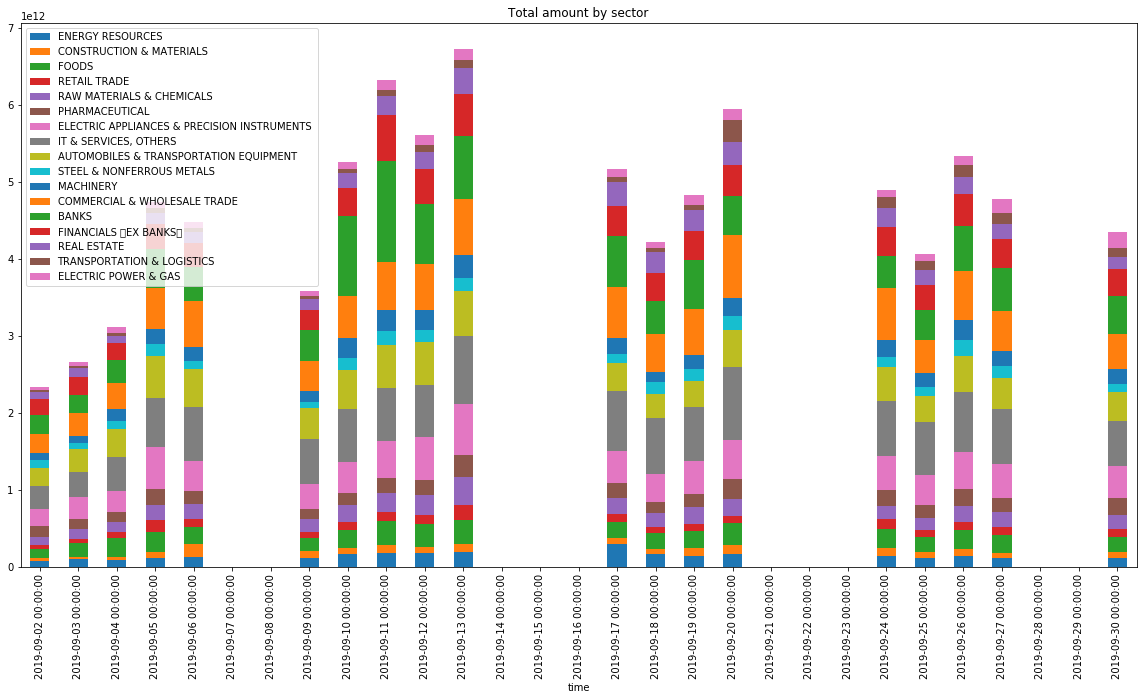

In [11]:
amounts_by_sector.plot(
    kind="bar", stacked=True, figsize=(20, 10),
    title="Total amount by sector"
)

# Autocorrelation

In [12]:
buf = []
for c in amounts.columns:
    buf.append((c, amounts[c].resample("D").sum().reset_index()[c].autocorr()))
high_correlation = pd.DataFrame.from_records(buf, columns=["symbol", "autocorr"]).set_index('symbol').idxmax().values[0]

In [13]:
lookup_security_info(high_correlation)

,Effective Date,Local Code,Name (English),Section/Products,33 Sector(Code),33 Sector(name),17 Sector(Code),17 Sector(name),Size Code (New Index Series),Size (New Index Series)
2822,20190930,7270,SUBARU CORPORATION,First Section (Domestic),3700,Transportation Equipment,6,AUTOMOBILES & TRANSPORTATION EQUIPMENT,2,TOPIX Large70


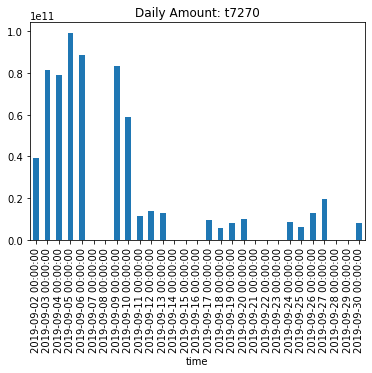

In [17]:
amounts[high_correlation].resample("D").sum().plot(kind="bar", title="Daily Amount: {}".format(high_correlation))

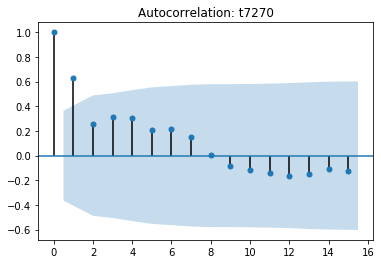

In [15]:
from statsmodels.graphics.tsaplots import plot_acf
_ = plot_acf(
    amounts[high_correlation].resample("D").sum().reset_index()[high_correlation],
    title="Autocorrelation: {}".format(high_correlation))